# Version 1.0

## Data Sources

**OpenWeatherMap**: Smooth data and accurate compared to Google Weather data 

**Open-Mateo**: Very quick to download and free, also provides ensemble forecasting for day ahead timeframe

    Note: Convention to put the target column in the first column (index = 0)

## Regression
**Still to be hyperparamater tuned, to serve as baseline for future models**

- Random Forests
- kNN 
- xGBoost 
- Ridge 

**Notes:**
- Very lightweight models and trains fast on Laptop resources, able to track the seasonality of the wind speed.
- Easily able to incorporate uni-variate and multi-variate structures where the multi-variate forecasting is slightly more acurate.

- Rollout does not work as well as having multiple outputs

**Preliminary results**
- The OWM data was proved more suitable for the models to adjust and learn

**To-do**

- Tune hyperparameters
- Play with the windowsize

## Deep-Learning

**PyTorch vs TensorFlow**

[Read the differences ](https://www.turing.com/kb/pytorch-vs-tensorflow)

**Still to be designed and tested**
- NN
- CNN
- RNN
- LSTM
- GNN
- LGBM

_Examples at:_

[Set Scholars](https://setscholars.net/)





# Imports

In [2]:
from shared_utilities import *

# Setup

In [47]:
train_ = False
uni = True

window_size = 24*3 # 24 for OWM and 23 for OM
step = 24

if uni:
    column_ = 0
else:
    column_ = None

dm = WeatherDataModule(data_dir='data\Sere Wind Farm_hourly_OWM.csv', 
                       window_size=window_size, column=column_,
                       batch_size=32, step_=step, 
                       normalize_=True)

dm.prepare_data()
dm.setup('')

if train_:
    train(dm= dm, folder='models_FCST', train_models=True, rfr=True, xgb_=True, knn=True, ridge=True, window_size=window_size, step=step)
rfr_model, xgb_model, knn_model, ridge_model = load_models(dm = dm, folder='models_FCST', window_size=window_size, step=step)

Train: torch.Size([6050, 72])
Valid: torch.Size([1729, 72])
Test: torch.Size([768, 72])
Models loaded...


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


# Validate

MSE for Average model: 0.0038807437523064067
MSE for kNN model: 0.010431103
MSE for Ridge model: 0.003703977919012556
MSE for Random Forest model: 0.0036110886572843343
MSE for XGBoost model: 0.0035560231


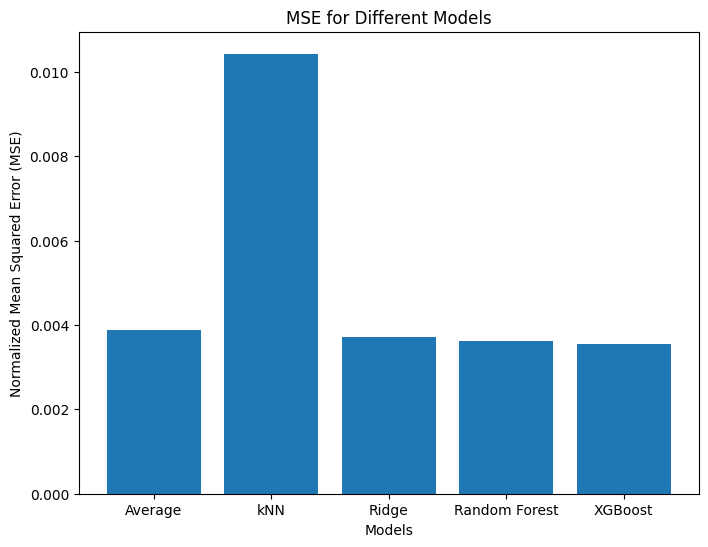

In [6]:
metrics(dm.column, dm.f_valid, dm.t_valid, rfr_model, xgb_model, knn_model, ridge_model, window_size, dm.df.shape[1])

# Inspect

## Logic Inspect 

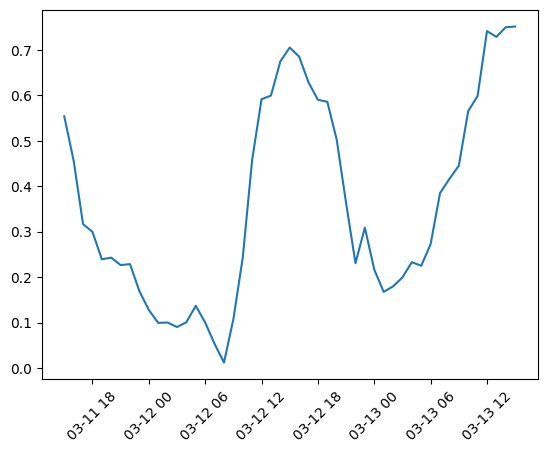

In [7]:
plt.plot(dm.df[dm.split[1]:dm.split[1] + window_size + step][0], label='Data')
plt.xticks(rotation=45)
plt.show()

## Full 

In [20]:
def rollout_randomforest(model, current_set, step=24, verbose=True):
        forecast_scaled = []
        if verbose:
            print('Running...')

        with torch.no_grad():
            for i in range(step):
                print(f'{i}/{step}', end='\r')
                prediction = model.predict(current_set.reshape(1, -1))
                forecast_scaled.append(prediction.item())
                current_set = current_set[1:]
                current_set = torch.cat((current_set, torch.tensor(prediction)), dim=0)

            if verbose:
                print('Completed')

            forecast = pd.Series(forecast_scaled)
            results_ = np.array(forecast.values).squeeze()

        return results_

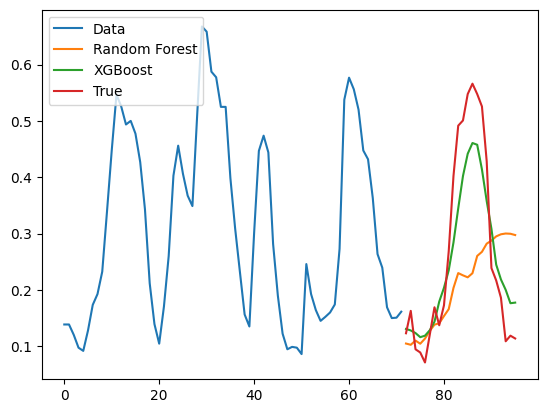

In [53]:
current_data_ = dm.f_valid[0].reshape(1, window_size * dm.df.shape[1])

step_pred_rfr = rfr_model.predict(current_data_).squeeze()


plt.plot(np.arange(window_size),dm.f_valid[0], label='Data')
plt.plot(np.arange(window_size,window_size+24),pred_rfr, label='Random Forest')
plt.plot(np.arange(window_size,window_size+24),step_pred_rfr, label='XGBoost')
plt.plot(np.arange(window_size,window_size+24),dm.t_valid[0], label='True')
plt.legend()
plt.show()

Mean MSE for Random Forest: 0.4534241530356941
Mean MSE for XGBoost: 0.5356922345446997
Mean MSE for kNN: 2.1591878323388665
Mean MSE for Ridge: 0.5002359236616643
Mean MSE for Average: 0.7236873323200387


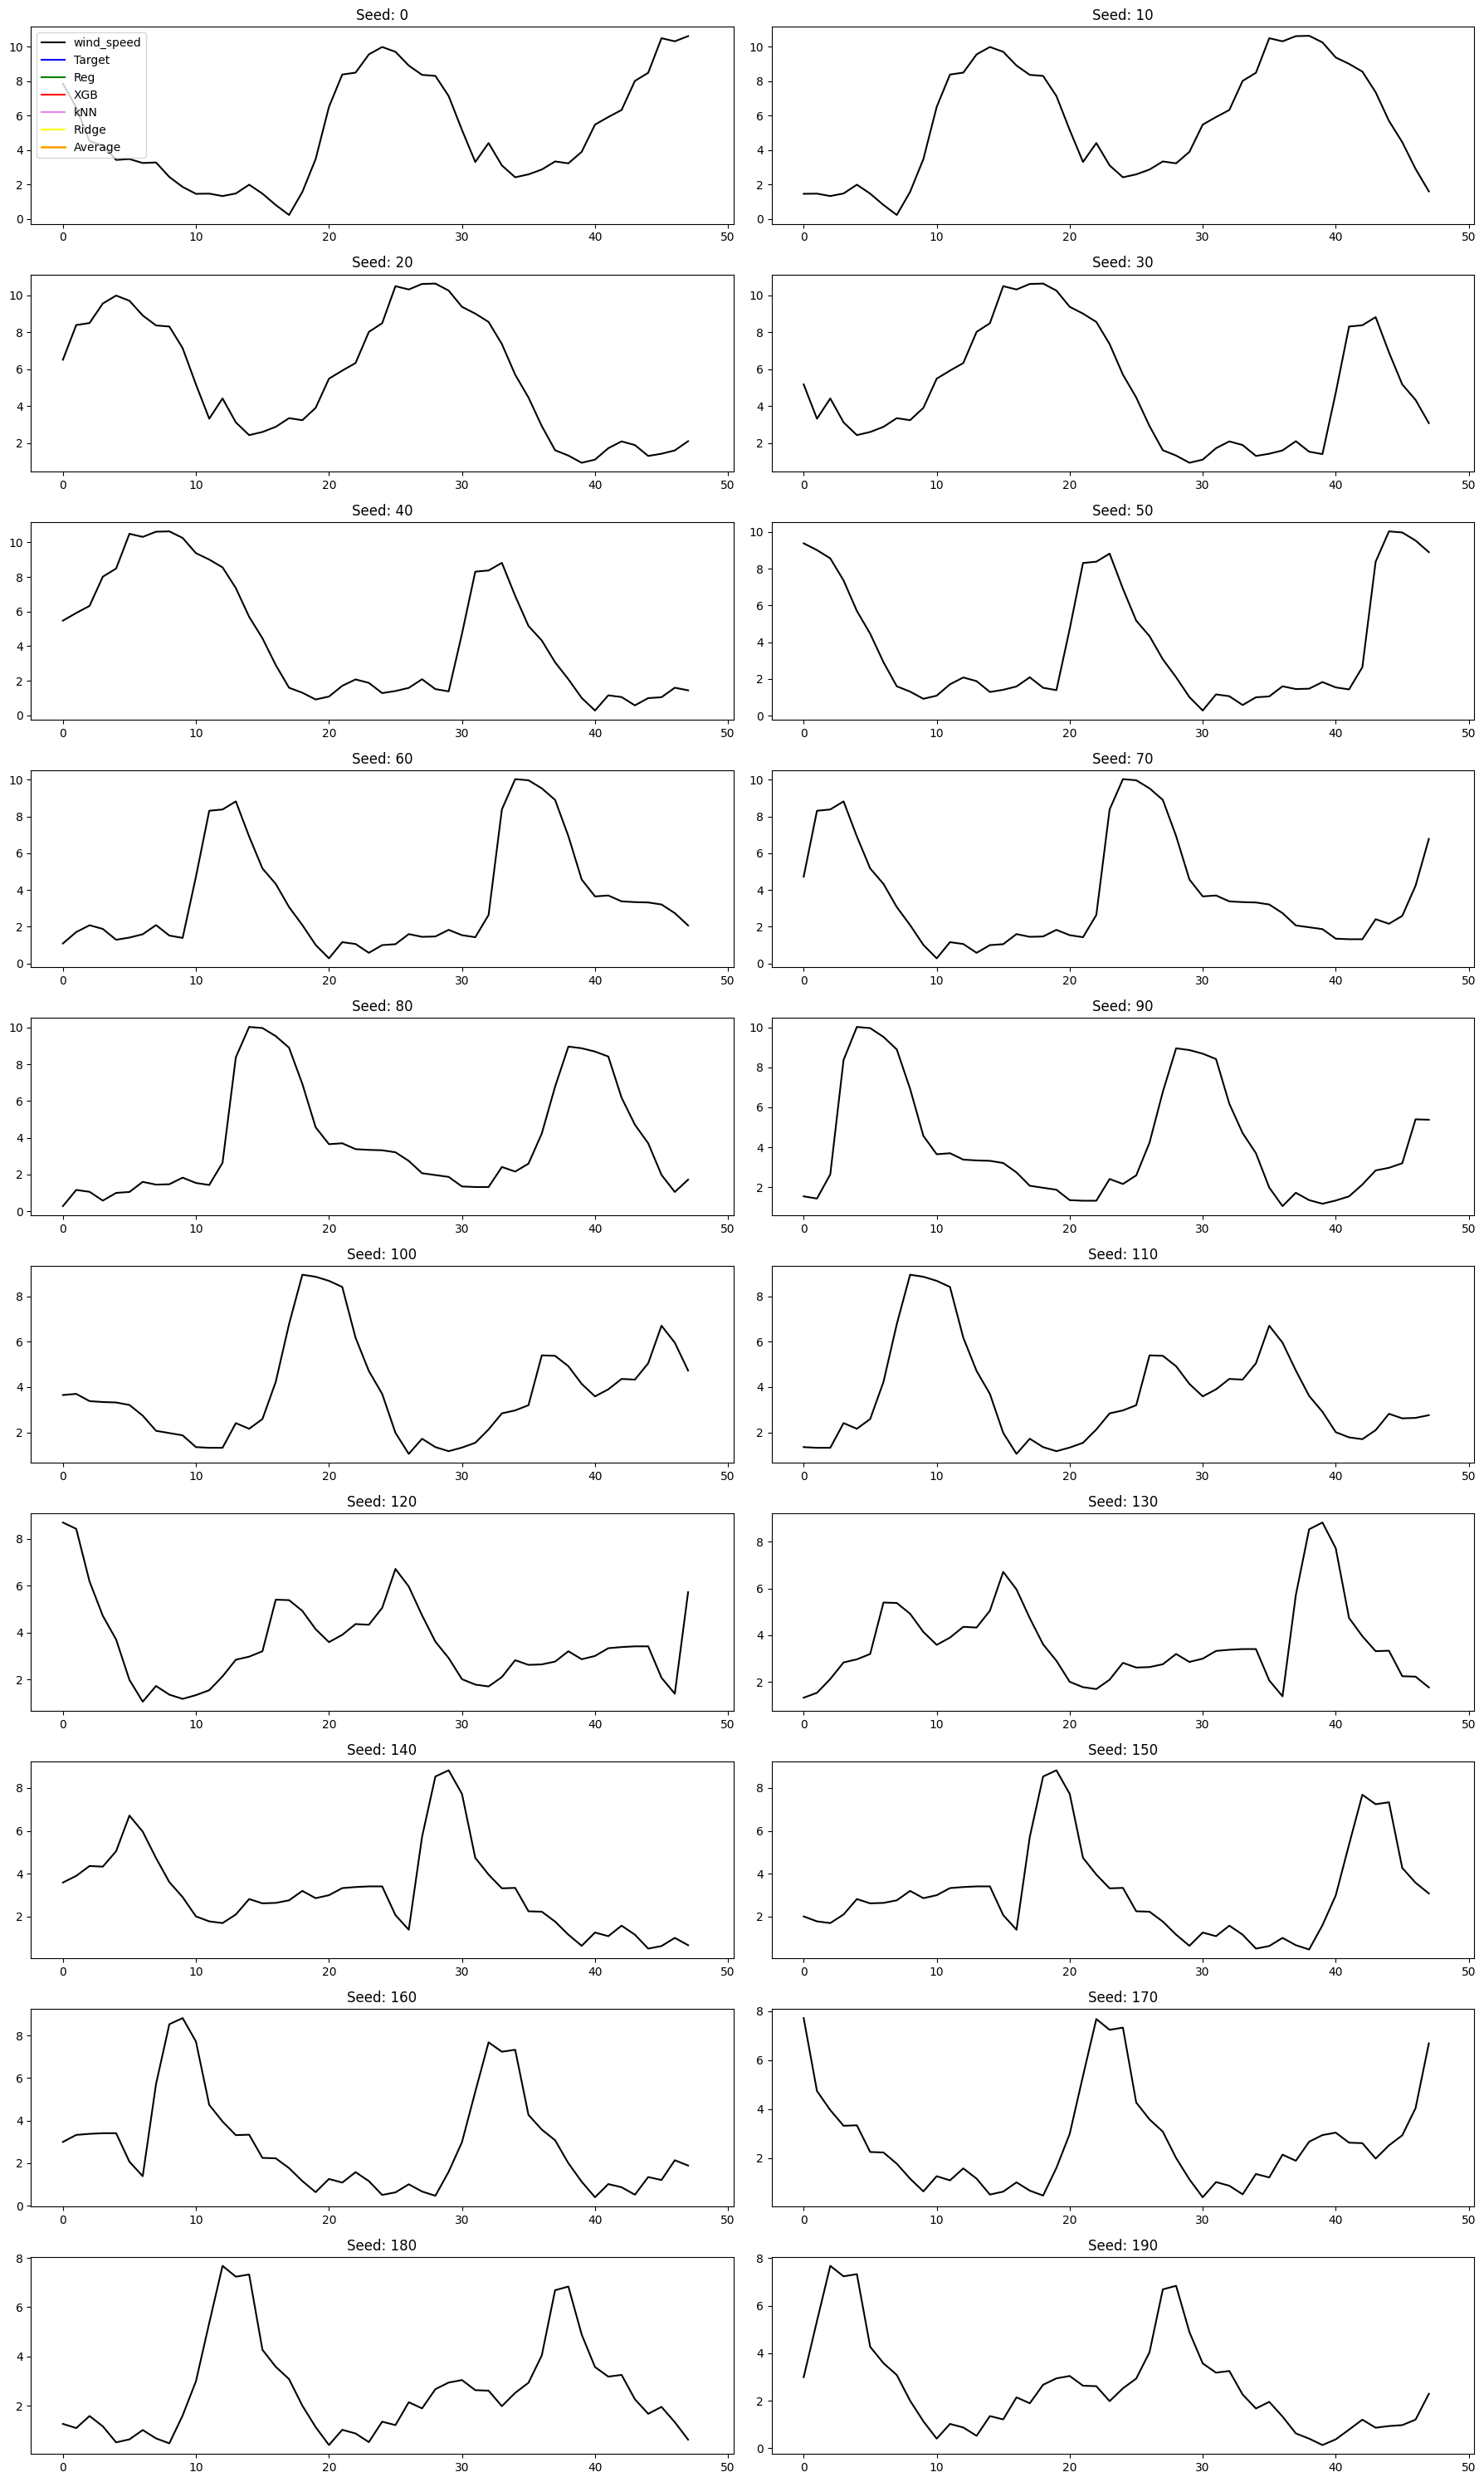

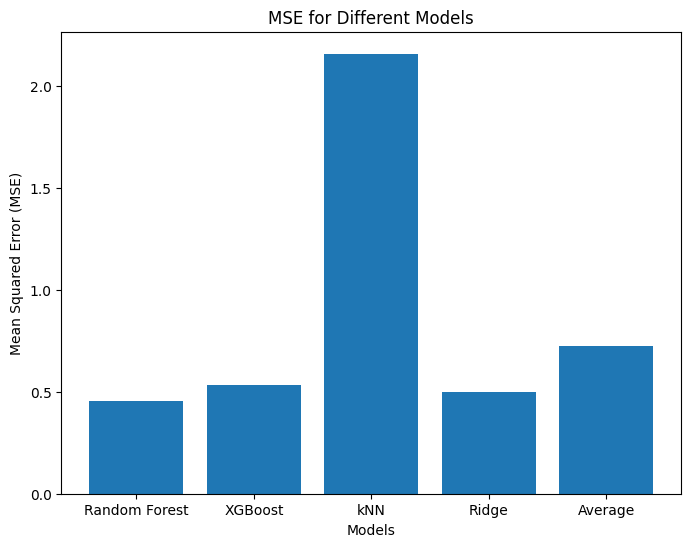

In [8]:
interval = 10

_ = plot_results(seed=0, height=10, width=2, interval=interval, X=dm.f_test, y=dm.t_test,
                 rfr_model= rfr_model, xgb_model=xgb_model, knn_model=knn_model, ridge_model=ridge_model, 
                 plot_features=False, metrics=True, window_size=window_size, step=step, dm=dm) 

# Final Metrics

MSE for Average model: 0.01746158899183786
MSE for kNN model: 0.024488619
MSE for Ridge model: 0.017016541073444736
MSE for Random Forest model: 0.019553520631659698
MSE for XGBoost model: 0.016755976


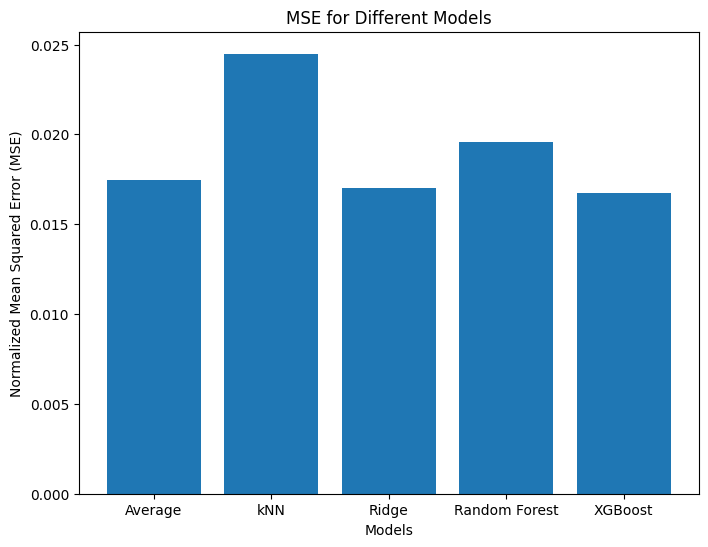

In [ ]:
metrics(dm.column, dm.f_test, dm.t_test, rfr_model, xgb_model, knn_model, ridge_model, window_size, dm.df.shape[1])